### This notebook is using a dataset found at Kaggle to predict whether a citrus fruit is an orange or grapefruit.

The given data is the diameter, weight, and rgb color of the fruit along with the identification. However, I was most interested in being able to classify without using color with the idea that a scale, to measure the weight, and a ruler to measure the diameter are definitive numbers, whereas identifying the color amount of RGB is not something a human can easily do.

To help with the classification, since this only left me with two features, I created new columns based on the two original columns of diameter and weight.

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
import xgboost as xgb

from scipy import stats

In [3]:
df = pd.read_csv('citrus.csv')

In [4]:
df.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [5]:
df['name'].value_counts() # perfectly balanced. Probably intentional.

grapefruit    5000
orange        5000
Name: name, dtype: int64

In [6]:
df.info() #no nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   name      10000 non-null  object 
 1   diameter  10000 non-null  float64
 2   weight    10000 non-null  float64
 3   red       10000 non-null  int64  
 4   green     10000 non-null  int64  
 5   blue      10000 non-null  int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 468.9+ KB


In [7]:
df.duplicated().unique() #no duplicates

array([False])

In [8]:
df.drop(['red', 'green', 'blue'], axis=1, inplace=True) # Remove colors

In [9]:
df.head()

,name,diameter,weight
0,orange,2.96,86.76
1,orange,3.91,88.05
2,orange,4.42,95.17
3,orange,4.47,95.60
4,orange,4.48,95.76


## Exploratory Data Analysis

I first visualize the two columns compared to the classification 'name', and see if there is good separation.

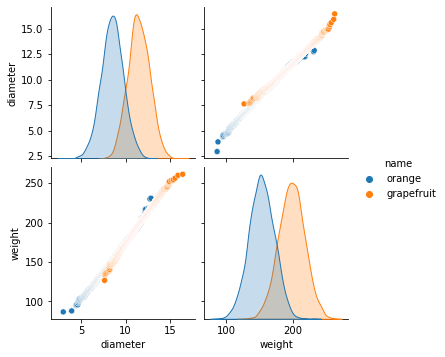

In [10]:
sns.pairplot(data=df, hue='name',)

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
diameter,10000.0,9.975685,1.947844,2.96,8.46,9.980,11.4800,16.45
weight,10000.0,175.050792,29.212119,86.76,152.22,174.985,197.7225,261.51


<AxesSubplot:xlabel='diameter', ylabel='Count'>

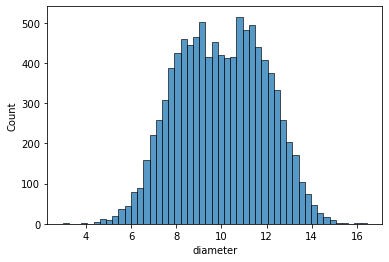

In [12]:
sns.histplot(data=df, x='diameter')

<AxesSubplot:xlabel='weight', ylabel='Count'>

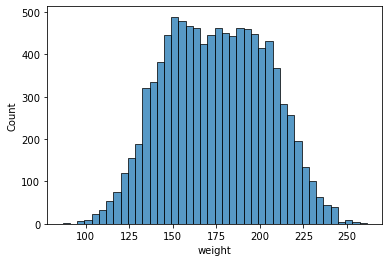

In [13]:
sns.histplot(data=df, x='weight')

The above graph shows that the diameter and weight for all the fruits appear to be linearly related; however, the kde plots show that oranges have a smaller diameter and weight.

Additionally, the data looks fairly normal, without many outliers. Since there were no duplicates or nulls, I will not remove any data.

Below are the two sample t-test statistics to see if there is a significant difference between these two features (diameter and weight) for each fruit.

In [14]:
# Compare the data of orange vs grapefruit with a two-sample ttest

orange = df[df['name']=='orange']
grapefruit = df[df['name']=='grapefruit']

columns = df.columns.drop('name')

for col in columns:
    orange_col = orange[col]
    grapefruit_col = grapefruit[col]
    
    stat, p_value = stats.ttest_ind(orange_col, grapefruit_col)
    
    print(f'For the feature {col}, the two sample t-test statistics and p-values are',
          f'{stat} and {p_value}, respectively',
          '\n\n')


For the feature diameter, the two sample t-test statistics and p-values are -120.96567386074341 and 0.0, respectively 


For the feature weight, the two sample t-test statistics and p-values are -117.49837000434881 and 0.0, respectively 




## Model Creation

The above shows that the weight and diameter features seem to be quite different with split on the label category, which means these two features could be good for classification.

I initially used a variety of models with grid searches, including Logistic Regression, SVC, Random Forest, and Ada Boost, but XGB Classifier blew the rest out of the water.

Additionally, in going through many grid searches, adding new features, I determined the model that was working best was the model using the data that added a density column, where density = weight / diameter**3, then applying a fourth degree polynomial conversion.

In further exploration of the feature importance, I noticed that the two features that were most important, aside from the original two, were weight*diameter and weight/diameter. The below CombinedAttributesAdder simply adds these two columns into the model, and when I reduced to just adding these two attributes, only weight/diameter remained the most important, so I only added that feature.

In [15]:
### Add attributes to the data for X

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        weight_over_diameter = X['weight'] / X['diameter']
        X_densities = np.c_[X, weight_over_diameter]
        
        return X_densities

In [16]:
# Split X and y
X = df.drop('name', axis=1)

# Need label_encoder since using XGBoost

le = LabelEncoder()
y = le.fit_transform(df['name'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [17]:
# Create models, pipelines, and the grid search for each

### Basic Model
xgbc = xgb.XGBClassifier(use_label_encoder=False, eval_metric='error')

### Pipeline
xgbc_pipe = Pipeline([
    ('attr_adder', CombinedAttributesAdder()), # Add the attributes
    ('xgbc', xgbc) # Run the model
])


### Hyper-paramters used in the GridSearch

n_estimators = [10, 50, 100]
learning_rates = [0.1, 0.5, 1, 2]
max_depths = [2, 3, 4]

xgbc_param_grid = {'xgbc__n_estimators': n_estimators,
                   'xgbc__max_depth': max_depths,
                   'xgbc__learning_rate': learning_rates,
                   'xgbc__booster': ['gbtree']}

In [18]:
def grid_search_results(model, param_grid):
    """
    Create grid search from the model and param_grid given.
    Then fit and return mean_test_score and best params.
    """
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print(f"Largest 5 mean test scores: {np.sort(grid.cv_results_['mean_test_score'])[::-1][:5]}")
    print('\n\n')
    print(f"Best params: {grid.best_params_}")
    
    return grid

In [19]:
xgbc_grid = grid_search_results(xgbc_pipe, xgbc_param_grid)

Largest 5 mean test scores: [0.99766667 0.99766667 0.99755556 0.99755556 0.99744444]



Best params: {'xgbc__booster': 'gbtree', 'xgbc__learning_rate': 0.5, 'xgbc__max_depth': 3, 'xgbc__n_estimators': 50}


The above shows quite an impressive result. By adding in the weight/diameter feature into the data, we get mean test scores around 99.75%. While 99.13% for the base data is a very good result (without the new feature), it is 0.87 off of 100, whereas 99.75 is only 0.25 off of 100, meaning we expect to pick wrong approximately 3.5x fewer.

In [20]:
### We will use this model as our final model.
### First check how it performs on test set.

def test_preds_metrics(model, X_test, y_test):
    """
    Put in a fitted model and test set.
    Return the predicitons. Print the
    classification report and confusion matrix"""
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))
    plot_confusion_matrix(model, X_test, y_test)
    
    return preds

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       1.00      1.00      1.00       492

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



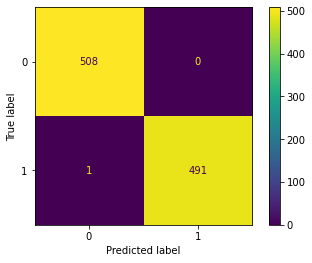

In [21]:
preds = test_preds_metrics(xgbc_grid, X_test, y_test)

As we can see, the model performs almost exactly the same on the test set as the validation set during training, only misclassifying 1/1000 for a 99.9% accuracy score.

I will retrain the model on the entirety of our data X to get the final model with the hyper-parameters found above.

In [22]:
xgbc = xgb.XGBClassifier(n_estimators=50,
                         max_depth=4,
                         learning_rate=0.5,
                         booster='gbtree',
                         eval_metric='error')

final_model = Pipeline([
    ('attr_adder', CombinedAttributesAdder()),
    ('xgbc', xgbc),
])

final_model.fit(X, y)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('attr_adder', CombinedAttributesAdder()),
                ('xgbc',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='error', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.5,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [27]:
final_model['xgbc'].feature_importances_ # diameter, weight, and weight/diameter

array([0.0507431 , 0.08174186, 0.867515  ], dtype=float32)

The new feature has very high importance (86.7%) compared to the two original features. This helps explain why the accuracy was much closer to 100 when adding this new feature.

In [31]:
from joblib import dump, load

In [32]:
# Save the model and the label encoder, that way the user can see the name of the citrus and not just a number.
dump(final_model, 'FinalCitrusClassificationModel.joblib')
dump(le, 'LabelEncoder.joblib')

['LabelEncoder.joblib']

In [33]:
# load them both up to use on random data
model = load('FinalCitrusClassificationModel.joblib')
label = load('LabelEncoder.joblib')

## Test model on random data

In [34]:
# Test on a few random rows in X just to see how it performs

rand_idx = np.random.randint(0,X.shape[0],size=50)

rand_data = X.iloc[rand_idx]

rand_preds = le.inverse_transform(final_model.predict(rand_data))

true_vals = df.iloc[rand_idx]['name']

pred_true_df = pd.DataFrame(index=rand_idx, 
                            data=np.c_[rand_preds, true_vals.to_numpy()], 
                            columns=['prediction', 'true value'])

print(accuracy_score(pred_true_df['prediction'], pred_true_df['true value']))

1.0


To simulate a user putting in a collection of diameters and weights to classify, I create a get_prediction function below that outputs the predictions, in order, based on the diameters/weights inputted.

In [35]:
def get_prediction(model, X, label_encoder):
    """
    Input a list of lists for diameter and weights.
    Output the prediction's name.
    """
    X_array = np.array(X)
    X_df = pd.DataFrame(data=X_array, columns=['diameter', 'weight'])
    preds = model.predict(X_df)
    preds_name = label_encoder.inverse_transform(preds)
    
    return preds_name

In [36]:
# Sample with a few random, but convert to a lists of lists

rand_idx = np.random.randint(0, X.shape[0], size=7)

rand_data = X.iloc[rand_idx]
rand_value = le.inverse_transform(y[rand_idx]) # random value that we want to predict correctly

sample_data = rand_data.to_numpy().tolist() # data for the random index chosen

pred_name = get_prediction(final_model, sample_data, le)

for i in range(len(sample_data)):
    print(f'The sample data was diameter {sample_data[i][0]} and weight {sample_data[i][1]}',
          f'The output value for this sample data was {rand_value[i]}',
          f'and the prediction is {pred_name[i]}.',
          f'\n\n')

The sample data was diameter 8.56 and weight 153.62 The output value for this sample data was orange and the prediction is orange. 


The sample data was diameter 8.75 and weight 156.65 The output value for this sample data was orange and the prediction is orange. 


The sample data was diameter 11.19 and weight 193.24 The output value for this sample data was grapefruit and the prediction is grapefruit. 


The sample data was diameter 9.95 and weight 175.45 The output value for this sample data was orange and the prediction is orange. 


The sample data was diameter 10.93 and weight 189.02 The output value for this sample data was grapefruit and the prediction is grapefruit. 


The sample data was diameter 12.2 and weight 208.36 The output value for this sample data was grapefruit and the prediction is grapefruit. 


The sample data was diameter 8.8 and weight 157.45 The output value for this sample data was orange and the prediction is orange. 




### Final Comments

With just knowing the weight and diameter of the fruit, our model was able to predict ~99.75% accuracy on the test/hold-out set by adding in one new feature column based on the two. I find this to be quite a valuable lesson, since I often notice, most of the time, new features are added in by multiplying (using a polynomial transformer), but division gives ratios, which I have found helpful for separating data in the past.